In [1]:
from ROOT import TMVA, TFile, TTree, TCut, TString
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Concatenate, Dense, LSTM, Input, Reshape, Dropout, RNN, BatchNormalization
from tensorflow.keras.optimizers import Adagrad, SGD, RMSprop, Adam
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import eli5
from eli5.sklearn import PermutationImportance
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import pandas as pd
import random
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_tree
from IPython import display
import graphviz
from numba import cuda
from array import array
import pickle
import scikitplot as skplt
import seaborn as sns
import pycuda.autoinit
import pycuda.driver as drv
from pycuda.compiler import SourceModule
from math import sqrt
import swats
import gc 

Welcome to JupyROOT 6.19/01


Load signal and background trees

In [2]:
def nextPowerTwo(n):
    n = n-1
    n = n >> 1 | n
    n = n >> 2 | n
    n = n >> 4 | n
    n = n >> 8 | n
    n = n >> 16 | n
    n = n+1
    return(n)

In [108]:
drv.init()
mod=SourceModule("""
__global__ void cuda_mean(double *a, double *c, int N)
{ 
  extern __shared__ double sharedMem[256];
  int index=threadIdx.x+blockIdx.x*blockDim.x;
  int stride=blockDim.x*gridDim.x;
  sharedMem[threadIdx.x]=0;
  //if(index<N){
    //sharedMem[threadIdx.x]=b[index];
  //}
  for(int i=index;i<N;i=i+stride){
     sharedMem[threadIdx.x]+=a[i];
  }
   
   __syncthreads();
   
   for(int offset=blockDim.x/2;offset>0;offset>>=1){
      if(threadIdx.x<offset){
      sharedMem[threadIdx.x]+=sharedMem[threadIdx.x+offset];
      }
      __syncthreads();
   }
   if(threadIdx.x==0){
      c[blockIdx.x]=sharedMem[0];
   }
   
}
""")
cuda_mean1=mod.get_function("cuda_mean") 

In [109]:
drv.init()
mod=SourceModule("""
__global__ void cuda_var1(double *a,double b, double *c, int N)
{ 
  extern __shared__ double sharedMem[256];
  int index=threadIdx.x+blockIdx.x*blockDim.x;
  int stride=blockDim.x*gridDim.x;
  sharedMem[threadIdx.x]=0;
  //if(index<N){
    //sharedMem[threadIdx.x]=b[index];
  //}
  for(int i=index;i<N;i=i+stride){
     sharedMem[threadIdx.x]+=(a[i]-b)*(a[i]-b);
  }
   
   __syncthreads();
   
   for(int offset=blockDim.x/2;offset>0;offset>>=1){
      if(threadIdx.x<offset){
      sharedMem[threadIdx.x]+=sharedMem[threadIdx.x+offset];
      }
      __syncthreads();
   }
   if(threadIdx.x==0){
      c[blockIdx.x]=sharedMem[0];
   }
   
}
""")
cuda_var1=mod.get_function("cuda_var1") 

In [110]:
drv.init()
mod=SourceModule("""
__global__ void cuda_normal1(double *a,double b, double c,double *d, int N)
{ 
  int index=threadIdx.x+blockIdx.x*blockDim.x;
  int stride=blockDim.x*gridDim.x;
  for(int i=index;i<N;i=i+stride){
     d[i]=(a[i]-b)/c;
  }
   
}
""")
cuda_normal1=mod.get_function("cuda_normal1") 

In [111]:
def cuda_mean(nump1):
    leng1,ncol=nump1.shape
    mean_num=np.zeros((ncol,1))
    result=np.zeros((ncol,1))
    nThreads=256
    nBlocks=68
    c1=np.zeros((68,1))
    for i in range(0,ncol):
        input_num=np.float64(nump1[:,i].copy(order='C'))
        N=np.int32(leng1)
        cuda_mean1(drv.InOut(input_num),drv.InOut(c1),N,block=(nThreads, 1, 1),grid=(nBlocks,1))
        result[i]=sum(c1)/leng1
    return(result)
        
        
        
    

In [112]:
def cuda_var(nump1):
    leng1,ncol=nump1.shape
    mean_vec=cuda_mean(nump1)
    result=np.zeros((ncol,1))
    nThreads=256
    nBlocks=68
    c1=np.zeros((68,1))
    
    for i in range(0,ncol):
        input_num=np.float64(nump1[:,i].copy(order='C'))
        N=np.int32(leng1)
        mean1=mean_vec[i]
        cuda_var1(drv.InOut(input_num),mean1,drv.InOut(c1),N,block=(nThreads, 1, 1),grid=(nBlocks,1))
        result[i]=sum(c1)/(leng1-1)
    return(result)
    
    

In [113]:
def guass_normal(nump1,nump2):
    leng1,ncol=nump1.shape
    mean_vec=cuda_mean(nump2)
    var_vec=cuda_var(nump2)
    result=np.zeros((leng1,ncol))
    for i in range(0,ncol):
        result[:,i]=(nump1[:,i]-mean_vec[i])/sqrt(var_vec[i]+0.001)
    return(result)
    


In [114]:
def min_max_renormal(numpy_array,numpy_array1):
    mydf = pd.DataFrame(data=numpy_array)
    mydf1 = pd.DataFrame(data=numpy_array1)
    normalize_df = (mydf-mydf1.min())/(mydf1.max()-mydf1.min())
    normalize_np = normalize_df.values
    print(normalize_np)
    return(normalize_np)

In [10]:
signalFile = TFile.Open("../samples-train/tree_ZH_modify.root")
backgroundFile = TFile.Open("../samples-train/tree_bkg.root")

In [11]:
signalTree = signalFile.Get("tree_NOMINAL")
backgroundTree = backgroundFile.Get("tree_NOMINAL")

In [12]:
signalNum = signalTree.GetEntries()
backgroundNum = backgroundTree.GetEntries()
print("signal events number before cut is: ", signalNum)
print("background events number before cut is: ", backgroundNum)

signal events number before cut is:  23046
background events number before cut is:  155486


Convert minitree into numpy

In [13]:
signalArray=signalTree.AsMatrix(["weight","MH","MZ","PtL1","PtL2","PtL3","PtL4","PtH","PtZ","PtZH","dRH","dRZ","dRHZ","dPhiHZ","dEtaHZ","KarS","Met","Met_sig","Met_Phi","Ht","M4l","Mt2lMET","Mt4lMET"])
#signalArray=signalTree.AsMatrix(["weight","is_em","is_me","bjet_0_eta","bjet_1_pt","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                                #"bb_pt","bb_deltar","bb_deltaeta","met_sig","met_phi","mt_lep0_met","mt_lep1_met"])
    
#backgroundArray=backgroundTree.AsMatrix(["weight","is_em","is_me","bjet_0_eta","bjet_1_pt","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                                #"bb_pt","bb_deltar","bb_deltaeta","met_sig","met_phi","mt_lep0_met","mt_lep1_met"])
backgroundArray=backgroundTree.AsMatrix(["weight","MH","MZ","PtL1","PtL2","PtL3","PtL4","PtH","PtZ","PtZH","dRH","dRZ","dRHZ","dPhiHZ","dEtaHZ","KarS","Met","Met_sig","Met_Phi","Ht","M4l","Mt2lMET","Mt4lMET"])
    
print(signalArray.shape)

(23046, 23)


In [14]:
leng,ncol=signalArray.shape
print(leng)
print(ncol)

23046
23


In [15]:
for i in range(0,ncol):
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22


In [16]:
print("signal yield before cut is: ",sum(signalArray[:,0]))
print("background yield before cut is:",sum(backgroundArray[:,0]))

signal yield before cut is:  0.6566021626500835
background yield before cut is: 521.4996971364277


In [17]:
dataSignal=pd.DataFrame(data=signalArray[:,1:],columns=["MH","MZ","PtL1","PtL2","PtL3","PtL4","PtH","PtZ","PtZH","dRH","dRZ","dRHZ","dPhiHZ","dEtaHZ","KarS","Met","Met_sig","Met_Phi","Ht","M4l","Mt2lMET","Mt4lMET"])

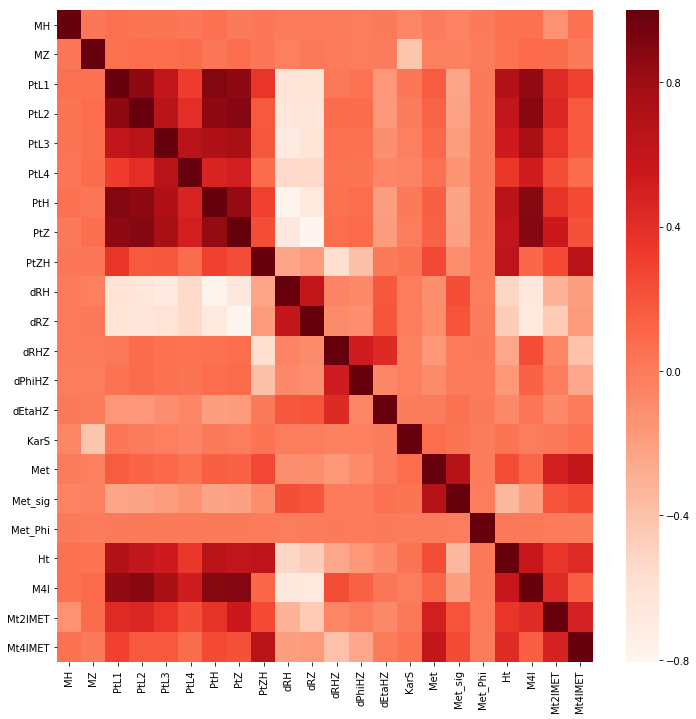

In [18]:
plt.figure(figsize=(12, 12))
cor = dataSignal.corr()
cor.style.set_precision(2)
sns.heatmap(cor, annot=False, cmap=plt.cm.Reds)
figure_fig = plt.gcf()  # 'get current figure'

figure_fig.savefig('../figure/0819/corr_sig.pdf', format='pdf', dpi=500)

plt.show()

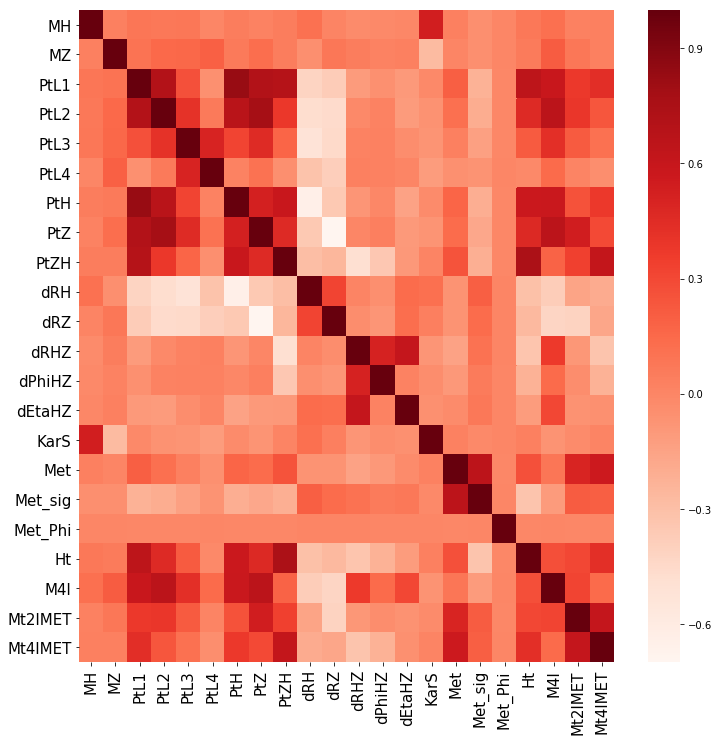

In [19]:
dataBackground = pd.DataFrame(data=backgroundArray[:, 1:], columns=["MH","MZ","PtL1","PtL2","PtL3","PtL4","PtH","PtZ","PtZH","dRH","dRZ","dRHZ","dPhiHZ","dEtaHZ","KarS","Met","Met_sig","Met_Phi","Ht","M4l","Mt2lMET","Mt4lMET"])
plt.figure(figsize=(12, 12))
cor = dataBackground.corr()
sns.heatmap(cor, annot=False, cmap=plt.cm.Reds)
figure_fig = plt.gcf()  # 'get current figure'
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
figure_fig.savefig('../figure/0819/corr_bkg.pdf', format='pdf', dpi=500)
plt.show()

In [20]:
print(signalArray)

[[1.02972879e-04 1.26325469e+02 9.21984447e+01 ... 2.58855319e+02
  9.68744012e+01 9.45111893e+01]
 [1.11745701e-04 1.22227364e+02 8.98526132e+01 ... 3.02104405e+02
  6.74024163e+01 3.31930904e+01]
 [7.77473854e-05 1.23357895e+02 9.14760586e+01 ... 2.53544628e+02
  8.27595671e+01 7.68222908e+01]
 ...
 [1.85710009e-04 1.25629838e+02 9.69372604e+01 ... 3.18801415e+02
  8.63746121e+01 3.44359213e+01]
 [2.49880759e-04 1.16986349e+02 8.65699771e+01 ... 2.58280666e+02
  4.79338728e+01 4.17277456e+01]
 [1.82353060e-04 1.21930852e+02 9.17860443e+01 ... 2.54508310e+02
  1.32247138e+02 1.46800059e+02]]


In [21]:
print(signalArray[:,1])

[126.32546926 122.22736428 123.35789507 ... 125.62983766 116.98634881
 121.93085227]


Add signal Region cuts $m_{jj}>300$ Gev and $|\Delta(y_{jj})|>2.0$.

In [22]:
signalSample2=signalArray
backgroundSample2=backgroundArray#[(abs(backgroundArray[:,7])<75000.0)&((backgroundArray[:,1]==1)|(backgroundArray[:,2]==1))]

In [23]:
print(len(signalSample2))
print(len(backgroundSample2))

23046
155486


In [24]:
signalNum=len(signalSample2)
backgroundNum=len(backgroundSample2)
print("signal event number after cut is: ",signalNum)
print("background event number after cut is:",backgroundNum)
print("signal yield after cut is: ",sum(signalSample2[:,0]))
print("background yield after cut is:",sum(backgroundSample2[:,0]))
SBratio=sum(signalSample2[:,0])/sum(backgroundSample2[:,0])
print("S/B ratio is: ",SBratio)
SigYield=sum(signalSample2[:,0])
BkgYield=sum(backgroundSample2[:,0])

signal event number after cut is:  23046
background event number after cut is: 155486
signal yield after cut is:  0.6566021626500835
background yield after cut is: 521.4996971364277
S/B ratio is:  0.0012590652808726602


In [25]:
signalSample=signalSample2#[(signalSample2[:,12]>80000)&(signalSample2[:,12]<150000)&(signalSample2[:,14]<2.8)]
backgroundSample=backgroundSample2#[(backgroundSample2[:,12]>80000)&(backgroundSample2[:,12]<150000)&(backgroundSample2[:,14]<2.8)]

In [26]:
dataNormal=np.vstack((signalSample,backgroundSample))

In [27]:
print(dataNormal)

[[1.02972879e-04 1.26325469e+02 9.21984447e+01 ... 2.58855319e+02
  9.68744012e+01 9.45111893e+01]
 [1.11745701e-04 1.22227364e+02 8.98526132e+01 ... 3.02104405e+02
  6.74024163e+01 3.31930904e+01]
 [7.77473854e-05 1.23357895e+02 9.14760586e+01 ... 2.53544628e+02
  8.27595671e+01 7.68222908e+01]
 ...
 [3.59136241e-02 1.16964709e+02 9.20139328e+01 ... 2.97613912e+02
  1.49747307e+02 1.38228686e+02]
 [3.53918291e-02 1.42036123e+02 8.84913107e+01 ... 3.25262589e+02
  7.24569368e+01 7.97585719e+01]
 [5.10326577e-02 1.20452254e+02 1.00052993e+02 ... 2.60228370e+02
  1.57641785e+02 1.64325722e+02]]


In [28]:
print(len(signalSample))
print(len(backgroundSample))

23046
155486


In [29]:
signalNum=len(signalSample)
backgroundNum=len(backgroundSample)
print("signal event number after cut is: ",signalNum)
print("background event number after cut is:",backgroundNum)
print("signal yield after cut is: ",sum(signalSample[:,0]))
print("background yield after cut is:",sum(backgroundSample[:,0]))
SBratio=sum(signalSample[:,0])/sum(backgroundSample[:,0])
print("S/B ratio is: ",SBratio)
SigYield1=sum(signalSample[:,0])
BkgYield1=sum(backgroundSample[:,0])

signal event number after cut is:  23046
background event number after cut is: 155486
signal yield after cut is:  0.6566021626500835
background yield after cut is: 521.4996971364277
S/B ratio is:  0.0012590652808726602


Split datasets into training and testing subsets

In [30]:
trainingRatio=0.8
sigTrainNum=int(signalNum*0.8)
backgroundTrainNum=int(backgroundNum*0.8)
sigTestNum=signalNum-sigTrainNum
backgroundTestNum=backgroundNum-backgroundTrainNum
print("training signal events number is: ",sigTrainNum)
print("testing signal events number is: ",sigTestNum)
print("training background events number is: ",backgroundTrainNum)
print("testing background events number is: ",backgroundTestNum)


training signal events number is:  18436
testing signal events number is:  4610
training background events number is:  124388
testing background events number is:  31098


In [31]:
signal_row=np.arange(0,signalNum-1,1)
background_row=np.arange(0,backgroundNum-1,1)
signal_train_row=np.random.choice(signal_row,size=sigTrainNum,replace=False)
background_train_row=np.random.choice(background_row,size=backgroundTrainNum,replace=False)
label_signal_train=np.ones((sigTrainNum,1))
label_background_train=np.zeros((backgroundTrainNum,1))
label_signal_test=np.ones((sigTestNum,1))
label_background_test=np.zeros((backgroundTestNum,1))
signalTrain1=signalSample[signal_train_row,:]
signalTest1=np.delete(signalSample,signal_train_row,axis=0)
backgroundTrain1=backgroundSample[background_train_row,:]
backgroundTest1=np.delete(backgroundSample,background_train_row,axis=0)
signalTrain1=np.concatenate((label_signal_train,signalTrain1),axis=1)
backgroundTrain1=np.concatenate((label_background_train,backgroundTrain1),axis=1)
signalTrain=signalTrain1[(signalTrain1[:,1]>0)]
backgroundTrain=backgroundTrain1[(backgroundTrain1[:,1]>0)]
signalTest1=np.concatenate((label_signal_test,signalTest1),axis=1)
backgroundTest1=np.concatenate((label_background_test,backgroundTest1),axis=1)
signalTest=signalTest1[(signalTest1[:,1]>0)]
backgroundTest=backgroundTest1[(backgroundTest1[:,1]>0)]
ratio=sum(signalTrain[:,1])/sum(backgroundTrain[:,1])
signalTrain[:,1]=signalTrain[:,1]/ratio
print(backgroundTest)
print(ratio)
ratio1=sum(signalTest[:,1])/sum(backgroundTest[:,1])
signalTest[:,1]=signalTest[:,1]/ratio1

[[0.00000000e+00 1.25338313e-02 1.31799517e+02 ... 2.85338975e+02
  1.05904201e+02 1.39914802e+01]
 [0.00000000e+00 3.28754091e-02 1.39226140e+02 ... 2.62624863e+02
  3.97456211e+01 3.45692129e+01]
 [0.00000000e+00 3.54791795e-02 1.48011459e+02 ... 3.16666445e+02
  1.19429532e+01 8.46862374e+01]
 ...
 [0.00000000e+00 5.81318700e-03 1.11743226e+02 ... 3.65874758e+02
  1.52719344e+01 2.82607957e+01]
 [0.00000000e+00 1.04277439e-02 1.49319550e+02 ... 2.70066741e+02
  4.63845116e+01 1.63398616e+02]
 [0.00000000e+00 5.10326577e-02 1.20452254e+02 ... 2.60228370e+02
  1.57641785e+02 1.64325722e+02]]
0.0009988871974317033


In [32]:
dataTrain=np.vstack((signalTrain,backgroundTrain))
dataTest=np.vstack((signalTest,backgroundTest))
np.random.shuffle(dataTrain)
np.random.shuffle(dataTest)
dataTrainLabel=dataTrain[:,0]
dataTrainWeight=dataTrain[:,1]
dataTrainSample=dataTrain[:,3:]
dataTestLabel=dataTest[:,0]
dataTestWeight=dataTest[:,1]
dataTestSample=dataTest[:,3:]
tf.cast(dataTrainLabel,tf.float32)
tf.cast(dataTrainSample,tf.float32)

<tf.Tensor 'Cast_1:0' shape=(129522, 21) dtype=float32>

Signal and background training sets should have same yield in training

(array([0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

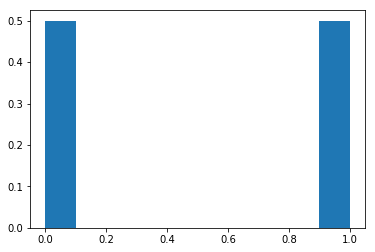

In [33]:
dataTrainWeight=dataTrainWeight/sum(dataTrainWeight)
plt.hist(dataTrain[:,0],weights=dataTrainWeight)

In [34]:
average_train_weight=dataTrainWeight.mean()

(array([0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

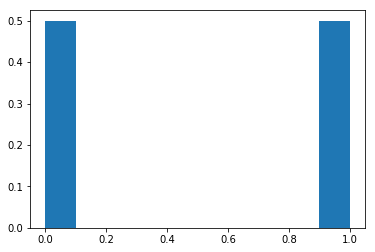

In [35]:
dataTestWeight=dataTestWeight/sum(dataTestWeight)
plt.hist(dataTest[:,0],weights=dataTestWeight)

In [36]:
average_test_weight=dataTestWeight.mean()

Build model

In [37]:
print(guass_normal(signalSample[:,2:],dataNormal[:,2:]))

[[ 0.38059823 -0.58696922 -0.14283192 ... -0.30420011  1.16498519
   0.96738281]
 [ 0.18907335  0.41239086  1.35978446 ...  0.10336476  0.43392502
  -0.41101615]
 [ 0.32161918 -0.61456636 -0.13176057 ... -0.35424628  0.8148631
   0.56974557]
 ...
 [ 0.76749774  0.26008178  0.78081627 ...  0.26071179  0.90453522
  -0.38307795]
 [-0.07893671 -0.18017352 -0.00234755 ... -0.30961545 -0.04899722
  -0.21916154]
 [ 0.34692789  0.17262709  0.81227294 ... -0.34516486  2.04241505
   2.14280938]]


In [38]:
dataTrainSample1=guass_normal(dataTrainSample,dataNormal[:,2:])
dataTestSample1=guass_normal(dataTestSample,dataNormal[:,2:])

In [39]:
signalSample1=signalSample[(signalSample[:,1]>120.0)&(signalSample[:,1]<130.0)]
backgroundSample1=backgroundSample[(backgroundSample[:,1]>120.0)&(backgroundSample[:,1]<130.0)]
SBratio=sum(signalSample1[:,0])/sum(backgroundSample1[:,0])
print("S/B ratio is: ",SBratio)
SigYield=sum(signalSample1[:,0])
BkgYield=sum(backgroundSample1[:,0])

S/B ratio is:  0.0041821994364116205


In [115]:
signalSample2=guass_normal(signalSample1[:,2:],dataNormal[:,2:])
backgroundSample2=guass_normal(backgroundSample1[:,2:],dataNormal[:,2:])

In [ ]:
model = Sequential()
model.add(Dense(300, kernel_initializer="glorot_normal", activation="relu",
    input_dim=21))
model.add(BatchNormalization(momentum=0.5, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None))
model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
model.add(BatchNormalization(momentum=0.5, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None))
model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
model.add(BatchNormalization(momentum=0.5, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None))
model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
model.add(BatchNormalization(momentum=0.5, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None))
model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
model.add(BatchNormalization(momentum=0.5, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None))
model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
model.add(Dense(1, kernel_initializer="glorot_uniform", activation="sigmoid"))

# Set loss, optimizer and evaluation metrics
model.compile(
     loss="binary_crossentropy",
     #optimizer=Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
      optimizer='adam',
     #optimizer=SGD(lr=0.01, momentum=0.5, decay=0.8, nesterov=True),
     metrics=["acc"])

In [ ]:
early_stopping=tf.keras.callbacks.EarlyStopping(monitor='loss',
                              min_delta=0,
                              patience=3,
                              verbose=0, mode='auto')

In [ ]:
model.save('model_HHZZ.h5')
model.summary()

In [ ]:
model.fit(dataTrainSample1,dataTrainLabel,batch_size=100, epochs=30,
          sample_weight=dataTrainWeight,
          callbacks=[early_stopping])

In [ ]:
signalNN=model.predict(signalSample1)
backgroundNN=model.predict(backgroundSample1)
plt.hist(signalNN,bins=20)
plt.hist(backgroundNN,bins=20)
NNTrainScore=model.predict(dataTrainSample1)

In [ ]:
plt.hist(backgroundNN,bins=20,weights=backgroundSample[:,0])

In [ ]:
plt.hist(signalNN,bins=20,weights=signalSample[:,0])

In [ ]:
backgroundNN=model.predict(backgroundSample1)
plt.hist(backgroundNN,bins=20)

Save NN model to h5 file

In [ ]:
model.save('../NN_model/0716/_NNmodel_region4.h5')
model.summary()

In [ ]:
signalNNScore=model.predict(signalSample1)
#backgroundNNScore=model.predict(backgroundArray[:,1:])
print(signalNNScore)

In [ ]:
plt.hist(signalNNScore,bins=20)

In [ ]:
def baseline_model():
    model = Sequential()
    model.add(Dense(300, kernel_initializer="glorot_normal", activation="relu",
         input_dim=21))
    model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
    model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
    model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
    model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
    model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
    model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
    model.add(Dense(1, kernel_initializer="glorot_uniform", activation="sigmoid"))
    model.compile(
     loss="binary_crossentropy",
     optimizer="adam",
     metrics=["accuracy"])
    return model

In [ ]:
estimator = KerasRegressor(build_fn=baseline_model, nb_epoch=30, batch_size=50, verbose=False)
estimator.fit(dataTrainSample1,dataTrainLabel,sample_weight=dataTrainWeight)
perm = PermutationImportance(estimator, random_state=1).fit(dataTrainSample1,dataTrainLabel)

In [ ]:
eli5.show_weights(perm,feature_names=["bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                                "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet"])

In [ ]:
cuda.select_device(0)
cuda.close()

In [60]:
drv.init()
device = torch.device("cuda:0")
y_tensor = torch.tensor(dataTrainLabel, dtype=torch.float).to(device)
WeightTensor=torch.tensor((dataTrainWeight), dtype=torch.float).to(device)
dataTrainTensor=torch.tensor(dataTrainSample1, dtype=torch.float).to(device)
dataTestTensor=torch.tensor(dataTestSample1,dtype=torch.float).to(device)
TrainDataset = TensorDataset( WeightTensor, dataTrainTensor, y_tensor)
TrainLoader = DataLoader(TrainDataset, batch_size=500, shuffle=False)
TestWeightTensor=torch.tensor(dataTestWeight,dtype=torch.float).to(device)
test_y_tensor=torch.tensor(dataTestLabel, dtype=torch.float).to(device)
TestDataset = TensorDataset((TestWeightTensor), dataTestTensor, test_y_tensor)
TestLoader = DataLoader(TestDataset, batch_size=500, shuffle=False)

In [61]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(21, 300)
        self.relu1 = nn.ReLU()
        self.dout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(300, 300)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(300,300)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(300, 300)
        self.relu4 = nn.ReLU()
        self.out = nn.Linear(300, 1)
        self.out_act = nn.Sigmoid()
        
    def forward(self, input_):
        a1 = self.fc1(input_)
        h1 = self.relu1(a1)
        dout = self.dout(h1)
        a2 = self.fc2(dout)
        h2 = self.relu2(a2)
        a3 = self.fc2(h2)
        h3 = self.relu3(a3)
        a4 = self.fc2(h3)
        h4 = self.relu4(a4)
        a5 = self.out(h4)
        y = self.out_act(a5)
        return y

In [62]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0.01)

In [63]:
def custom_loss(y_pred,y,weights):
    loss=torch.mean((y*torch.exp(5*(1-y_pred))+(1-y)*torch.exp(5*(y_pred)))*weights)
    return loss

In [64]:
def train(model, device, train_loader, loss_function, optimizer, epoch):
    model.train()
    average_loss=0
    batch_n=0
    for batch_idx, (sample_weight, data, target) in enumerate(train_loader):
        batch_n=batch_n+1
        data, target,sample_weight = data, target, sample_weight
        
        optimizer.zero_grad()
        data=data.squeeze()
        output = model(data)
        loss_function.weight = sample_weight/average_train_weight
        #my_weight=sample_weight/sample_weight.mean()
        output=output.reshape(-1)
        loss = loss_function(output, target)
        #loss = custom_loss(output, target,my_weight)
        loss.backward()
        average_loss=average_loss+loss.item()
        optimizer.step()
        torch.cuda.empty_cache()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    print("Average loss in epoch ",epoch," is: ",average_loss/batch_n)
    return(average_loss/batch_n)

In [65]:
def eval_train(model,device,input_loader,loss_function):
    average_loss=0
    batch_n=0
    model.eval()
    with torch.no_grad():
        for batch_idx, (sample_weight, data, target) in enumerate(input_loader):
            batch_n=batch_n+1
            data, target,sample_weight = data, target, sample_weight
            output = model(data)
            output=output.reshape(-1)
            loss_function.weight = sample_weight/average_test_weight
            loss = loss_function(output, target)
            average_loss=average_loss+loss.item()
    return(average_loss/batch_n)

In [66]:
model = Net().to(device)
model.apply(init_weights)

Net(
  (fc1): Linear(in_features=21, out_features=300, bias=True)
  (relu1): ReLU()
  (dout): Dropout(p=0.2)
  (fc2): Linear(in_features=300, out_features=300, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=300, out_features=300, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=300, out_features=300, bias=True)
  (relu4): ReLU()
  (out): Linear(in_features=300, out_features=1, bias=True)
  (out_act): Sigmoid()
)

In [67]:
loss_fn =nn.BCELoss().cuda()
#loss_fn=custom_loss()
#optimizer = optim.Adam(model.parameters())
optimizer=swats.SWATS(model.parameters())
#optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.6)
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

In [68]:
lowest_loss=9999
counter=0
best_epoch=0
pat=10
loss_np=np.zeros((300,1))
loss_test_np=np.zeros((300,1))
for epoch in range(1, 300):
        loss_epoch=train(model, device, TrainLoader,loss_fn, optimizer, epoch)
        loss_test_epoch=eval_train(model, device, TestLoader,loss_fn)
        loss_np[epoch-1]=loss_epoch
        loss_test_np[epoch-1]=loss_test_epoch
        loss_eval_epoch=(4.0*loss_test_epoch+loss_epoch)/5.0
        if(loss_eval_epoch<lowest_loss):
            counter=0
            best_epoch=epoch
            lowest_loss=loss_eval_epoch
        else:
            counter=counter+1
        if(counter==pat):
            print("Stopping, best epoch is: ",best_epoch," lowest loss is: ",lowest_loss)
            break
        

Train Epoch: 1 [0/129522 (0%)]	Loss: 0.704581
Train Epoch: 1 [5000/129522 (4%)]	Loss: 0.452499
Train Epoch: 1 [10000/129522 (8%)]	Loss: 0.438407
Train Epoch: 1 [15000/129522 (12%)]	Loss: 0.411085
Train Epoch: 1 [20000/129522 (15%)]	Loss: 0.332509
Train Epoch: 1 [25000/129522 (19%)]	Loss: 0.386579
Train Epoch: 1 [30000/129522 (23%)]	Loss: 0.388033
Train Epoch: 1 [35000/129522 (27%)]	Loss: 0.389999
Train Epoch: 1 [40000/129522 (31%)]	Loss: 0.353147
Train Epoch: 1 [45000/129522 (35%)]	Loss: 0.582664
Train Epoch: 1 [50000/129522 (38%)]	Loss: 0.347892
Train Epoch: 1 [55000/129522 (42%)]	Loss: 0.282405
Train Epoch: 1 [60000/129522 (46%)]	Loss: 0.254289
Train Epoch: 1 [65000/129522 (50%)]	Loss: 0.291580
Train Epoch: 1 [70000/129522 (54%)]	Loss: 0.312844
Train Epoch: 1 [75000/129522 (58%)]	Loss: 0.254190
Train Epoch: 1 [80000/129522 (62%)]	Loss: 0.515961
Train Epoch: 1 [85000/129522 (65%)]	Loss: 0.283163
Train Epoch: 1 [90000/129522 (69%)]	Loss: 0.344845
Train Epoch: 1 [95000/129522 (73%)]	Los

Train Epoch: 7 [0/129522 (0%)]	Loss: 0.237191
Train Epoch: 7 [5000/129522 (4%)]	Loss: 0.312870
Train Epoch: 7 [10000/129522 (8%)]	Loss: 0.300161
Train Epoch: 7 [15000/129522 (12%)]	Loss: 0.307939
Train Epoch: 7 [20000/129522 (15%)]	Loss: 0.283984
Train Epoch: 7 [25000/129522 (19%)]	Loss: 0.242241
Train Epoch: 7 [30000/129522 (23%)]	Loss: 0.333720
Train Epoch: 7 [35000/129522 (27%)]	Loss: 0.284646
Train Epoch: 7 [40000/129522 (31%)]	Loss: 0.261157
Train Epoch: 7 [45000/129522 (35%)]	Loss: 0.550668
Train Epoch: 7 [50000/129522 (38%)]	Loss: 0.257580
Train Epoch: 7 [55000/129522 (42%)]	Loss: 0.243345
Train Epoch: 7 [60000/129522 (46%)]	Loss: 0.198921
Train Epoch: 7 [65000/129522 (50%)]	Loss: 0.258838
Train Epoch: 7 [70000/129522 (54%)]	Loss: 0.245214
Train Epoch: 7 [75000/129522 (58%)]	Loss: 0.226613
Train Epoch: 7 [80000/129522 (62%)]	Loss: 0.323630
Train Epoch: 7 [85000/129522 (65%)]	Loss: 0.230944
Train Epoch: 7 [90000/129522 (69%)]	Loss: 0.288308
Train Epoch: 7 [95000/129522 (73%)]	Los

Average loss in epoch  12  is:  0.25722531011471383
Train Epoch: 13 [0/129522 (0%)]	Loss: 0.248286
Train Epoch: 13 [5000/129522 (4%)]	Loss: 0.254654
Train Epoch: 13 [10000/129522 (8%)]	Loss: 0.284058
Train Epoch: 13 [15000/129522 (12%)]	Loss: 0.262792
Train Epoch: 13 [20000/129522 (15%)]	Loss: 0.406951
Train Epoch: 13 [25000/129522 (19%)]	Loss: 0.244653
Train Epoch: 13 [30000/129522 (23%)]	Loss: 0.361647
Train Epoch: 13 [35000/129522 (27%)]	Loss: 0.239007
Train Epoch: 13 [40000/129522 (31%)]	Loss: 0.215404
Train Epoch: 13 [45000/129522 (35%)]	Loss: 0.407101
Train Epoch: 13 [50000/129522 (38%)]	Loss: 0.259473
Train Epoch: 13 [55000/129522 (42%)]	Loss: 0.219984
Train Epoch: 13 [60000/129522 (46%)]	Loss: 0.186858
Train Epoch: 13 [65000/129522 (50%)]	Loss: 0.233911
Train Epoch: 13 [70000/129522 (54%)]	Loss: 0.284556
Train Epoch: 13 [75000/129522 (58%)]	Loss: 0.231744
Train Epoch: 13 [80000/129522 (62%)]	Loss: 0.288444
Train Epoch: 13 [85000/129522 (65%)]	Loss: 0.235227
Train Epoch: 13 [900

Train Epoch: 18 [120000/129522 (92%)]	Loss: 0.236692
Train Epoch: 18 [125000/129522 (96%)]	Loss: 0.219595
Average loss in epoch  18  is:  0.2407992371572898
Train Epoch: 19 [0/129522 (0%)]	Loss: 0.230662
Train Epoch: 19 [5000/129522 (4%)]	Loss: 0.246570
Train Epoch: 19 [10000/129522 (8%)]	Loss: 0.255141
Train Epoch: 19 [15000/129522 (12%)]	Loss: 0.236983
Train Epoch: 19 [20000/129522 (15%)]	Loss: 0.222457
Train Epoch: 19 [25000/129522 (19%)]	Loss: 0.252868
Train Epoch: 19 [30000/129522 (23%)]	Loss: 0.364159
Train Epoch: 19 [35000/129522 (27%)]	Loss: 0.246549
Train Epoch: 19 [40000/129522 (31%)]	Loss: 0.210159
Train Epoch: 19 [45000/129522 (35%)]	Loss: 0.436309
Train Epoch: 19 [50000/129522 (38%)]	Loss: 0.253624
Train Epoch: 19 [55000/129522 (42%)]	Loss: 0.223589
Train Epoch: 19 [60000/129522 (46%)]	Loss: 0.194506
Train Epoch: 19 [65000/129522 (50%)]	Loss: 0.197415
Train Epoch: 19 [70000/129522 (54%)]	Loss: 0.286443
Train Epoch: 19 [75000/129522 (58%)]	Loss: 0.196255
Train Epoch: 19 [80

Train Epoch: 24 [105000/129522 (81%)]	Loss: 0.233220
Train Epoch: 24 [110000/129522 (85%)]	Loss: 0.221527
Train Epoch: 24 [115000/129522 (88%)]	Loss: 0.183486
Train Epoch: 24 [120000/129522 (92%)]	Loss: 0.174041
Train Epoch: 24 [125000/129522 (96%)]	Loss: 0.179736
Average loss in epoch  24  is:  0.22385552981151985
Train Epoch: 25 [0/129522 (0%)]	Loss: 0.211716
Train Epoch: 25 [5000/129522 (4%)]	Loss: 0.228466
Train Epoch: 25 [10000/129522 (8%)]	Loss: 0.223908
Train Epoch: 25 [15000/129522 (12%)]	Loss: 0.211920
Train Epoch: 25 [20000/129522 (15%)]	Loss: 0.208238
Train Epoch: 25 [25000/129522 (19%)]	Loss: 0.204886
Train Epoch: 25 [30000/129522 (23%)]	Loss: 0.289921
Train Epoch: 25 [35000/129522 (27%)]	Loss: 0.219060
Train Epoch: 25 [40000/129522 (31%)]	Loss: 0.229228
Train Epoch: 25 [45000/129522 (35%)]	Loss: 0.264015
Train Epoch: 25 [50000/129522 (38%)]	Loss: 0.241497
Train Epoch: 25 [55000/129522 (42%)]	Loss: 0.187657
Train Epoch: 25 [60000/129522 (46%)]	Loss: 0.176917
Train Epoch: 25

Train Epoch: 30 [90000/129522 (69%)]	Loss: 0.238461
Train Epoch: 30 [95000/129522 (73%)]	Loss: 0.186347
Train Epoch: 30 [100000/129522 (77%)]	Loss: 0.209077
Train Epoch: 30 [105000/129522 (81%)]	Loss: 0.214510
Train Epoch: 30 [110000/129522 (85%)]	Loss: 0.213187
Train Epoch: 30 [115000/129522 (88%)]	Loss: 0.236825
Train Epoch: 30 [120000/129522 (92%)]	Loss: 0.160669
Train Epoch: 30 [125000/129522 (96%)]	Loss: 0.207738
Average loss in epoch  30  is:  0.2101532881649641
Train Epoch: 31 [0/129522 (0%)]	Loss: 0.201154
Train Epoch: 31 [5000/129522 (4%)]	Loss: 0.238503
Train Epoch: 31 [10000/129522 (8%)]	Loss: 0.220803
Train Epoch: 31 [15000/129522 (12%)]	Loss: 0.228094
Train Epoch: 31 [20000/129522 (15%)]	Loss: 0.197474
Train Epoch: 31 [25000/129522 (19%)]	Loss: 0.211621
Train Epoch: 31 [30000/129522 (23%)]	Loss: 0.277052
Train Epoch: 31 [35000/129522 (27%)]	Loss: 0.203850
Train Epoch: 31 [40000/129522 (31%)]	Loss: 0.212768
Train Epoch: 31 [45000/129522 (35%)]	Loss: 0.305131
Train Epoch: 31

Train Epoch: 36 [75000/129522 (58%)]	Loss: 0.180061
Train Epoch: 36 [80000/129522 (62%)]	Loss: 0.224763
Train Epoch: 36 [85000/129522 (65%)]	Loss: 0.181461
Train Epoch: 36 [90000/129522 (69%)]	Loss: 0.233909
Train Epoch: 36 [95000/129522 (73%)]	Loss: 0.180196
Train Epoch: 36 [100000/129522 (77%)]	Loss: 0.166255
Train Epoch: 36 [105000/129522 (81%)]	Loss: 0.220533
Train Epoch: 36 [110000/129522 (85%)]	Loss: 0.222897
Train Epoch: 36 [115000/129522 (88%)]	Loss: 0.199743
Train Epoch: 36 [120000/129522 (92%)]	Loss: 0.159388
Train Epoch: 36 [125000/129522 (96%)]	Loss: 0.169340
Average loss in epoch  36  is:  0.19669822881428095
Stopping, best epoch is:  26  lowest loss is:  0.283388553662942


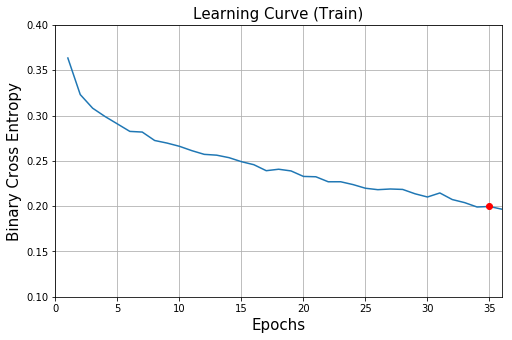

In [69]:
loss_train=loss_np[:best_epoch+pat,0]
train_step=range(1,best_epoch+pat+1)
fig, ax = plt.subplots(figsize=(8,5))
ax.set_ylabel('Binary Cross Entropy',fontsize=15)
ax.set_xlabel('Epochs',fontsize=15)
ax.set_title('Learning Curve (Train)',fontsize=15)
ax.grid()
x = train_step
y = loss_train
l = ax.plot(x, y)
dot, = ax.plot([], [], 'ro')
def init():
    ax.set_xlim(0,best_epoch+pat)
    ax.set_ylim(0.1,0.4)
    return l

def gen_dot():
    for i in range(1,best_epoch+pat):
        newdot = [x[i-1], y[i-1]]
        yield newdot

def update_dot(newd):
    dot.set_data(newd[0], newd[1])
    return dot,

ani = animation.FuncAnimation(fig, update_dot, frames = gen_dot, interval = 100, init_func=init)
ani.save('../figure/0819/loss-region4.gif', writer='imagemagick', fps=30)
plt.show()

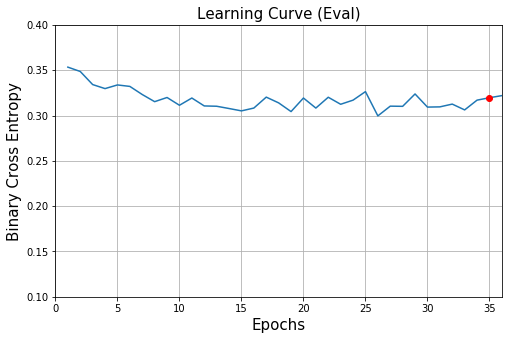

In [70]:
loss_train=loss_test_np[:best_epoch+pat,0]
train_step=range(1,best_epoch+pat+1)
fig, ax = plt.subplots(figsize=(8,5))
ax.set_ylabel('Binary Cross Entropy',fontsize=15)
ax.set_xlabel('Epochs',fontsize=15)
ax.set_title('Learning Curve (Eval)',fontsize=15)
ax.grid()
x = train_step
y = loss_train
l = ax.plot(x, y)
dot, = ax.plot([], [], 'ro')
def init():
    ax.set_xlim(0,best_epoch+pat)
    ax.set_ylim(0.1,0.4)
    return l

def gen_dot():
    for i in range(1,best_epoch+pat):
        newdot = [x[i-1], y[i-1]]
        yield newdot

def update_dot(newd):
    dot.set_data(newd[0], newd[1])
    return dot,

ani = animation.FuncAnimation(fig, update_dot, frames = gen_dot, interval = 100, init_func=init)
ani.save('../figure/0819/loss-region4-test.gif', writer='imagemagick', fps=30)
plt.show()

In [71]:
del TrainLoader
torch.cuda.empty_cache()
del TrainDataset
torch.cuda.empty_cache()
#del dataTrainTensor
#torch.cuda.empty_cache()
del WeightTensor
torch.cuda.empty_cache()

In [72]:
def eval_pytorch(model,device,input_loader):
    output_numpy=[1]
    model.eval()
    with torch.no_grad():
        for batch_idx, (data1) in enumerate(input_loader):
            score=model(data1)
            del data1
            score_np=score.data.cpu().numpy()
            output_numpy=np.vstack((output_numpy,score_np))
            torch.cuda.empty_cache()
    return(output_numpy)

In [73]:
signalTensor = torch.tensor(signalSample2, dtype=torch.float, device=device)
signalLoader=DataLoader(signalTensor,batch_size=10000, shuffle=False)

[0.96421593 0.97299778 0.91534692 ... 0.95434719 0.99273902 0.92337257]
19010


(array([0.0023132 , 0.00163229, 0.0012443 , 0.00130162, 0.0007024 ,
        0.00106587, 0.00067044, 0.00145002, 0.00094059, 0.00089106,
        0.00119506, 0.00128369, 0.00193419, 0.00246829, 0.003326  ,
        0.00464476, 0.00971358, 0.02340465, 0.09618809, 0.38987154]),
 array([2.33896462e-05, 4.99712731e-02, 9.99191565e-02, 1.49867040e-01,
        1.99814923e-01, 2.49762807e-01, 2.99710690e-01, 3.49658574e-01,
        3.99606457e-01, 4.49554341e-01, 4.99502224e-01, 5.49450108e-01,
        5.99397991e-01, 6.49345874e-01, 6.99293758e-01, 7.49241641e-01,
        7.99189525e-01, 8.49137408e-01, 8.99085292e-01, 9.49033175e-01,
        9.98981059e-01]),
 <a list of 20 Patch objects>)

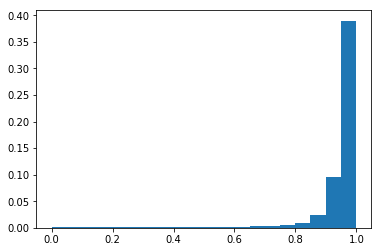

In [74]:
sigScore = eval_pytorch(model,device,signalLoader)
sigScore=sigScore[1:,0]
print(sigScore)
print(len(sigScore))
plt.hist(sigScore,bins=20,weights=signalSample1[:,0])

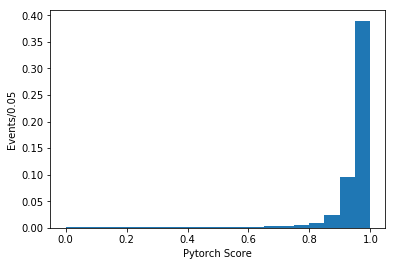

In [89]:
plt.hist(sigScore,bins=20,weights=signalSample1[:,0])
plt.ylabel('Events/0.05')
plt.xlabel('Pytorch Score')
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figure/0819/NN-region4-sig.pdf', format='pdf', dpi=500)
plt.show()

In [76]:
bakTensor= torch.tensor(backgroundSample2, dtype=torch.float,device=device)
backgroundLoader=DataLoader(bakTensor,batch_size=10000, shuffle=False)
bakScore = eval_pytorch(model,device,backgroundLoader)

In [77]:
bakScore=bakScore[1:,0]
print(bakScore)
print(len(bakScore))

[1.16118160e-03 7.34978297e-04 2.06114681e-04 ... 4.97172878e-05
 2.43897759e-03 8.31296275e-05]
40391


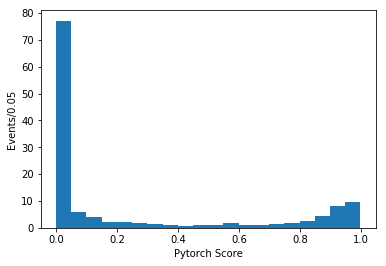

In [90]:
plt.hist(bakScore,bins=20,weights=backgroundSample1[:,0])
plt.ylabel('Events/0.05')
plt.xlabel('Pytorch Score')
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figure/0819/NN-region4-bkg.pdf', format='pdf', dpi=500)
plt.show()

In [ ]:
gc.collect()

In [ ]:
signalFile.Close()
backgroundFile.Close()

sigFile=TFile.Open("../sample-0718/bkg_fake.root", "update")
bkgFile=TFile.Open("../sample-0718/bkg_diboson.root","update")
sigTree=sigFile.Get("ntup")
bkgTree=bkgFile.Get("ntup")
sR1BDT=array("f",[0])
bR1BDT=array("f",[0])
sigRegion1BDTBranch=sigTree.Branch("BDT_Region1",sR1BDT,"BDT_Region1/F")
bkgRegion1BDTBranch=bkgTree.Branch("BDT_Region1",bR1BDT,"BDT_Region1/F")


In [ ]:
i=0
for (scoreR1,scoreR2,scoreR3,scoreR4) in zip(sigRegion1BDTScore,sigRegion2BDTScore,sigRegion3BDTScore,sigRegion4BDTScore):
    i=i+1
    if(i%5000==0):
        print("looping: ",i)
    sR1BDT[0]=scoreR1
    sR2BDT[0]=scoreR2
    sR3BDT[0]=scoreR3
    sR4BDT[0]=scoreR4
    sigRegion1BDTBranch.Fill()
    sigRegion2BDTBranch.Fill()
    sigRegion3BDTBranch.Fill()
    sigRegion4BDTBranch.Fill()
    
sigTree.Write()
sigFile.Write()
sigFile.Close()

In [85]:
dataTrainTensor= torch.tensor(dataTrainSample1, dtype=torch.float,device=device)
dataTrainLoader=DataLoader(dataTrainTensor,batch_size=100, shuffle=False)
TrainScore = eval_pytorch(model,device,dataTrainLoader)
TrainScore=TrainScore[1:,0]

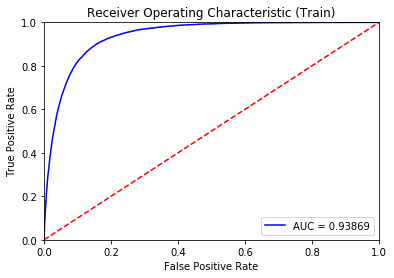

In [86]:
fpr, tpr, threshold=sklearn.metrics.roc_curve(dataTrainLabel,TrainScore)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic (Train)')
plt.plot(fpr, tpr, 'b',label = 'AUC = %0.5f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figure/0819/roc-region4-train-NN.pdf', format='pdf', dpi=500)
plt.show()

In [87]:
dataTestTensor= torch.tensor(dataTestSample1, dtype=torch.float,device=device)
dataTestLoader=DataLoader(dataTestTensor,batch_size=100, shuffle=False)
TestScore = eval_pytorch(model,device,dataTestLoader)
TestScore=TestScore[1:,0]

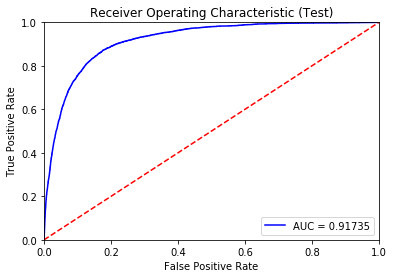

In [88]:
fpr, tpr, threshold=sklearn.metrics.roc_curve(dataTestLabel,TestScore)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic (Test)')
plt.plot(fpr, tpr, 'b',label = 'AUC = %0.5f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figure/0819/roc-region4-test-NN.pdf', format='pdf', dpi=500)
plt.show()

In [ ]:
torch.save(model,"../NN_model/region4-pytorch.pickle.dat")

In [ ]:
model.save_state_dict('../NN_model/region4-pytorch.pt')

In [133]:
torch.save(model.state_dict(),'../NN_model/hmumu-pytorch-0820.pt')

In [ ]:
del bakTensor
torch.cuda.empty_cache()

In [ ]:
cuda.select_device(0)
cuda.close()

In [ ]:
varName=["bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                              "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet"]
BDTtrain=xgb.DMatrix(dataTrainSample,label=dataTrainLabel,weight=dataTrainWeight,feature_names=varName)
BDTtest=xgb.DMatrix(dataTestSample,label=dataTestLabel,weight=dataTestWeight,feature_names=varName)
BDTSignal=xgb.DMatrix(signalSample[:,3:],feature_names=varName)
BDTBackground=xgb.DMatrix(backgroundSample[:,3:],feature_names=varName)
param = {'max_depth': 4, 'eta':0.1,'silent': 1, 'objective': 'binary:logistic'}
param['nthread'] = 16
param['eval_metric'] = 'auc'
param['tree_method'] = 'gpu_hist'
param['grow_policy'] = 'depthwise'
#param['subsample']=0.9
evallist = [(BDTtest, 'eval'), (BDTtrain, 'train')]
#eta_list=[0.1]*10+[0.05]*20+[0.02]*40+[0.01]*930

In [ ]:
num_round = 1000
GBDT = xgb.train(param, BDTtrain, num_round, evallist,early_stopping_rounds=5)

In [ ]:
GBDT=pickle.load(open("../BDT_model/GBDT_HH_region3-0.01.pickle.dat", "rb"))

In [ ]:
xgb.plot_importance(GBDT,importance_type="gain")
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figures/0725/ranking-region4-gain.pdf', format='pdf', dpi=500)

In [ ]:
xgb.plot_importance(GBDT,importance_type="weight")
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figures/0725/ranking-region4-weight.pdf', format='pdf', dpi=500)

In [ ]:
xgb.plot_importance(GBDT,importance_type="cover")
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figures/0725/ranking-region4-coverage.pdf', format='pdf', dpi=500)

In [ ]:
SignalScore=GBDT.predict(BDTSignal)
#plt.hist(SignalScore,bins=20)
BackgroundScore=GBDT.predict(BDTBackground)
plt.hist(BackgroundScore,bins=20,weights=backgroundSample[:,0])
plt.ylabel('Events/0.05')
plt.xlabel('BDT Score')
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figures/0725/BDT-region4-bkg.pdf', format='pdf', dpi=500)
plt.show()

In [ ]:
BackgroundScore=GBDT.predict(BDTBackground)
plt.hist(BackgroundScore,bins=20,range=[0.9, 1.0],weights=backgroundSample[:,0])
plt.ylabel('Events/0.05')
plt.xlabel('BDT Score')
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figures/0725/BDT-region4-bkg-high.pdf', format='pdf', dpi=500)
plt.show()

In [ ]:
BDTBackground1=xgb.DMatrix(backgroundArray[:,3:],feature_names=varName)
BackgroundScore1=GBDT.predict(BDTBackground1)
plt.hist(BackgroundScore1,bins=10,range=[0.9,1.0])
plt.ylabel('Events/0.05')
plt.xlabel('BDT Score')
plt.show()

In [ ]:
plt.hist(SignalScore,bins=20,weights=signalSample[:,0])
plt.ylabel('Events/0.05')
plt.xlabel('BDT Score')
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figures/0725/BDT-region4-sig.pdf', format='pdf', dpi=500)
plt.show()

In [ ]:
plot_tree(GBDT, num_trees=4)

In [ ]:
trainScore=GBDT.predict(BDTtrain)
testScore=GBDT.predict(BDTtest)
plt.hist(trainScore,bins=20)

In [ ]:
fpr, tpr, threshold=sklearn.metrics.roc_curve(dataTrainLabel,trainScore)
roc_auc = sklearn.metrics.auc(fpr, tpr)

In [ ]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label = 'AUC = %0.5f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figures/0725/roc-region4-train-BDT.pdf', format='pdf', dpi=500)
plt.show()

In [ ]:
fpr, tpr, threshold=sklearn.metrics.roc_curve(dataTrainLabel,NNTrainScore)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label = 'AUC = %0.5f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
pickle.dump(GBDT, open("../BDT_model/0716/GBDT_HH_region4_01.pickle.dat", "wb"))

In [ ]:
fpr, tpr, threshold=sklearn.metrics.roc_curve(dataTestLabel,testScore)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figures/0715/roc-region4-test.pdf', format='pdf', dpi=500)
plt.show()

In [123]:
drv.init()
mod=SourceModule("""
__global__ void func1(double *a, double *b, double *c,double thre, int N)
{ 
  extern __shared__ double sharedMem[256];
  double x=0;
  int index=threadIdx.x+blockIdx.x*blockDim.x;
  int stride=blockDim.x*gridDim.x;
  sharedMem[threadIdx.x]=0;
  //if(index<N){
    //sharedMem[threadIdx.x]=b[index];
  //}
  for(int i=index;i<N;i=i+stride){
     if(a[i]>thre){
     sharedMem[threadIdx.x]+=b[i];
     }
  }
   
   __syncthreads();
   
   for(int offset=blockDim.x/2;offset>0;offset>>=1){
      if(threadIdx.x<offset){
      sharedMem[threadIdx.x]+=sharedMem[threadIdx.x+offset];
      }
      __syncthreads();
   }
   if(threadIdx.x==0){
      c[blockIdx.x]=sharedMem[0];
   }
   
}
""")
func1=mod.get_function("func1") 

In [124]:
def cuda_sum(nump1,nump2,th):
    num1=np.float64(nump1.copy(order='C'))
    num2=np.float64(nump2.copy(order='C'))
    thres=np.float64(th)
    nThreads=256
    nBlocks=68
    c1=np.zeros((68,1))
    N=np.int32(len(nump1))
    func1(drv.InOut(num1),drv.InOut(num2),drv.InOut(c1),thres,N,block=(nThreads, 1, 1),grid=(nBlocks,1))
    return(sum(c1))

In [ ]:
resB=cuda_sum(BackgroundScore,backgroundSample[:,0],0.9)
resS=cuda_sum(SignalScore,signalSample[:,0],0.9)
SBratio1=resS/resB
Sig1=resS/sqrt(resB)
print("If cut BDT at 0.9, signal yield is:",resS," Eff is:", resS/SigYield," background yield is:",resB,
      " Eff is: ", resB/BkgYield," S/B ratio is: ",SBratio1," Significance is: ",Sig1)
resB=cuda_sum(BackgroundScore,backgroundSample[:,0],0.95)
resS=cuda_sum(SignalScore,signalSample[:,0],0.95)
SBratio2=resS/resB
Sig2=resS/sqrt(resB)
print("If cut BDT at 0.95, signal yield is:",resS," Eff is:", resS/SigYield," background yield is:",resB,
      " Eff is: ", resB/BkgYield," S/B ratio is: ",SBratio2," Significance is: ",Sig2)
resB=cuda_sum(BackgroundScore,backgroundSample[:,0],0.975)
resS=cuda_sum(SignalScore,signalSample[:,0],0.975)
SBratio3=resS/resB
Sig3=resS/sqrt(resB)
print("If cut BDT at 0.975, signal yield is:",resS," Eff is:", resS/SigYield," background yield is:",resB,
      " Eff is: ", resB/BkgYield," S/B ratio is: ",SBratio3," Significance is: ",Sig3)

In [ ]:
i=0.1
eff=(0.8,0.7,0.6,0.5,0.4,0.3)
j=0
print(eff)
for i in np.arange(0,1,0.001):
    resS=cuda_sum(SignalScore,signalSample[:,0],i)
    ratio=resS/SigYield
    if((abs(ratio-0.8)<0.01)|(abs(ratio-0.7)<0.001)|(abs(ratio-0.6)<0.01)|(abs(ratio-0.5)<0.01)|(abs(ratio-0.4)<0.01)):
        print("sig Eff: ",ratio," and BDT cut is: ",i)
    

In [ ]:
i=0.1
eff=(0.8,0.7,0.6,0.5,0.4,0.3)
j=0
k=0
t=0
min_diff=100
print(eff)
for i in np.arange(0,1,0.001):
    if(j>=6):
        break
    resS=cuda_sum(SignalScore,signalSample[:,0],i)
    ratio=resS/SigYield
    if(abs(ratio-eff[j])<0.05):
        t=1
        if(k==0):
            min_diff=100
        if(abs(ratio-eff[j])<min_diff):
            min_diff=abs(ratio-eff[j])
            BDT_cut=i
        k=k+1
           
    if(abs(ratio-eff[j])>0.05):
        if(t==1):
            j=j+1
            k=0
            t=0
            resB=cuda_sum(BackgroundScore,backgroundSample[:,0],BDT_cut)
            resS=cuda_sum(SignalScore,signalSample[:,0],BDT_cut)
            SBratio=resS/resB
            Sig=resS/sqrt(resB)
            print("If cut BDT at ",BDT_cut, "signal yield is:",resS," Eff is:", resS/SigYield," background yield is:",resB,
              " Eff is: ", resB/BkgYield," S/B ratio is: ",SBratio," Significance is: ",Sig)
    
    

In [ ]:
plt.hist(bakScore,bins=20,weights=backgroundSample[:,0])

In [ ]:
plt.hist(sigScore,bins=20,weights=signalSample[:,0])

In [98]:
i=0.1
eff=(0.98,0.9,0.8,0.7,0.6,0.5,0.4,0.3)
j=0
k=0
t=0
min_diff=100
print(eff)
for i in np.arange(0,1,0.001):
    if(j>=8):
        break
    resS=cuda_sum(sigScore,signalSample1[:,0],i)
    ratio=resS/SigYield
    if(abs(ratio-eff[j])<0.05):
        t=1
        if(k==0):
            min_diff=100
        if(abs(ratio-eff[j])<min_diff):
            min_diff=abs(ratio-eff[j])
            BDT_cut=i
        k=k+1
           
    if(abs(ratio-eff[j])>0.05):
        if(t==1):
            j=j+1
            k=0
            t=0
            resB=cuda_sum(bakScore,backgroundSample1[:,0],BDT_cut)
            resS=cuda_sum(sigScore,signalSample1[:,0],BDT_cut)
            SBratio=resS/resB
            Sig=resS/sqrt(resB)
            print("If cut NN at ",BDT_cut, "signal yield is:",resS," Eff is:", resS/SigYield," background yield is:",resB,
              " Eff is: ", resB/BkgYield," S/B ratio is: ",SBratio," Significance is: ",Sig)

(0.98, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3)
If cut NN at  0.422 signal yield is: [0.53532063]  Eff is: [0.98000699]  background yield is: [34.6767659]  Eff is:  [0.26549633]  S/B ratio is:  [0.01543744]  Significance is:  [0.09090645]
If cut NN at  0.891 signal yield is: [0.49138538]  Eff is: [0.89957509]  background yield is: [18.65560605]  Eff is:  [0.14283324]  S/B ratio is:  [0.02633982]  Significance is:  [0.11376733]
If cut NN at  0.934 signal yield is: [0.43718149]  Eff is: [0.80034449]  background yield is: [12.19806704]  Eff is:  [0.09339227]  S/B ratio is:  [0.03584023]  Significance is:  [0.12517461]
If cut NN at  0.9510000000000001 signal yield is: [0.381527]  Eff is: [0.69845828]  background yield is: [9.24807549]  Eff is:  [0.0708062]  S/B ratio is:  [0.04125475]  Significance is:  [0.12545836]
If cut NN at  0.962 signal yield is: [0.32518788]  Eff is: [0.59531873]  background yield is: [6.5291063]  Eff is:  [0.04998891]  S/B ratio is:  [0.04980588]  Significance is:  [0.12

In [99]:
print(len(sigScore[(sigScore>0.962)]))

10083


In [100]:
print(len(bakScore[(bakScore>0.962)]))

3705


In [102]:
DYFile= TFile.Open("../samples-train/tree_zmm_modify.root")
dibosonFile= TFile.Open("../samples-train/tree_diboson_modify.root")
ttbarFile= TFile.Open("../samples-train/tree_ttbar_modify.root")

In [103]:
DYTree=DYFile.Get("tree_NOMINAL")
dibosonTree=dibosonFile.Get("tree_NOMINAL")
ttbarTree=ttbarFile.Get("tree_NOMINAL")

In [104]:
DYArray=DYTree.AsMatrix(["weight","MH","MZ","PtL1","PtL2","PtL3","PtL4","PtH","PtZ","PtZH","dRH","dRZ","dRHZ","dPhiHZ","dEtaHZ","KarS","Met","Met_sig","Met_Phi","Ht","M4l","Mt2lMET","Mt4lMET"])
dibosonArray=dibosonTree.AsMatrix(["weight","MH","MZ","PtL1","PtL2","PtL3","PtL4","PtH","PtZ","PtZH","dRH","dRZ","dRHZ","dPhiHZ","dEtaHZ","KarS","Met","Met_sig","Met_Phi","Ht","M4l","Mt2lMET","Mt4lMET"])
ttbarArray=ttbarTree.AsMatrix(["weight","MH","MZ","PtL1","PtL2","PtL3","PtL4","PtH","PtZ","PtZH","dRH","dRZ","dRHZ","dPhiHZ","dEtaHZ","KarS","Met","Met_sig","Met_Phi","Ht","M4l","Mt2lMET","Mt4lMET"])


In [105]:
DYSample1=DYArray[(DYArray[:,1]>120.0)&(DYArray[:,1]<130.0)]
ttbarSample1=ttbarArray[(ttbarArray[:,1]>120.0)&(ttbarArray[:,1]<130.0)]
dibosonSample1=dibosonArray[(dibosonArray[:,1]>120.0)&(dibosonArray[:,1]<130.0)]

In [118]:
print(len(dibosonSample1))

39581


In [116]:
DYSample2=guass_normal(DYSample1[:,2:],dataNormal[:,2:])
dibosonSample2=guass_normal(dibosonSample1[:,2:],dataNormal[:,2:])
ttbarSample2=guass_normal(ttbarSample1[:,2:],dataNormal[:,2:])

In [119]:
DYTensor= torch.tensor(DYSample2, dtype=torch.float,device=device)
DYLoader=DataLoader(DYTensor,batch_size=100, shuffle=False)
DYScore = eval_pytorch(model,device,DYLoader)
DYScore=DYScore[1:,0]

In [121]:
ttbarTensor= torch.tensor(ttbarSample2, dtype=torch.float,device=device)
ttbarLoader=DataLoader(ttbarTensor,batch_size=100, shuffle=False)
ttbarScore = eval_pytorch(model,device,ttbarLoader)
ttbarScore=ttbarScore[1:,0]

In [122]:
dibosonTensor= torch.tensor(dibosonSample2, dtype=torch.float,device=device)
dibosonLoader=DataLoader(dibosonTensor,batch_size=100, shuffle=False)
dibosonScore = eval_pytorch(model,device,dibosonLoader)
dibosonScore=dibosonScore[1:,0]

In [129]:
print(cuda_sum(dibosonScore,dibosonSample1[:,0],0.962))

[6.64617164]


In [132]:
print(len(DYScore[(DYScore>0.962)]))

5


In [ ]:
for i in np.arange(0,1,0.001):
    resB=cuda_sum(BackgroundScore,backgroundSample[:,0],i)
    print(resB/BkgYield)
    

In [ ]:
print("If cut at 0.9,   improvment is: ",SBratio1/SBratio)
print("If cut at 0.95,  improvment is: ",SBratio2/SBratio)
print("If cut at 0.975, improvment is: ",SBratio3/SBratio)